In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
%matplotlib inline


In [80]:
left_top=[585, 456]
left_bottom =[253, 697]
right_top =[1061, 690]
right_bottom =[700, 456]


corners = np.float32([left_top,left_bottom, right_top,right_bottom])
offset = 150  #test the image to estimate a offset
img_size = (img.shape[1], img.shape[0])
src = np.float32(
    [corners[0],
     corners[1],
     corners[2],
     corners[3]])
#decide a place to place the birdviewed image, get these points by testing an image
dst = np.float32([
    [offset, 0], 
    [offset, img_size[1]],                         
    [img_size[0] - offset, img_size[1]],            
    [img_size[0] - offset,0]])  

grad_thresh=[20,100]
s_thresh=[170,255]

In [81]:
import pickle
#load distortion matrix from camera_cal
with open('./camera_cal/wide_dist_pickle.p',mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle['mtx']
    dist = dist_pickle["dist"]
print(mtx)
print(dist)
print('loaded mtx matrix and distortion matrix from undistortion')

[[1.15777930e+03 0.00000000e+00 6.67111054e+02]
 [0.00000000e+00 1.15282291e+03 3.86128938e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-0.24688775 -0.02373132 -0.00109842  0.00035108 -0.00258571]]
loaded mtx matrix and distortion matrix from undistortion


In [82]:
import glob
nx = 9
ny = 6
objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images
objpoints= []# 3d points in real world space
imgpoints= []# 2d points in image space

#make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

#Step through the list and search for chessboard corners
for frame in images:
    img = cv2.imread(frame)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

In [83]:
def get_shresholded_img(image,grad_thresh,s_thresh):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    #process the x direction gradient 
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= grad_thresh[0]) & (scaled_sobel <= grad_thresh[1])] = 1
    
    #process the HIS s channel 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

#     color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
# one can show it out to see the colored binary

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

In [84]:
def undistort_image(image, objectpoints, imagepoints):
    # Get image size
    img_size = (image.shape[1], image.shape[0])
    # Calibrate camera based on objectpoints, imagepoints, and image size
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpoints, imagepoints, img_size, None, None)
    # Call cv2.undistort
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    return dst

In [85]:
def warp_image_to_birdseye_view(image):
    image_size=(image.shape[1], image.shape[0])
    # Get perspective transform
    perspectiveTransform = cv2.getPerspectiveTransform(src, dst)
    # Warp perspective
    warped = cv2.warpPerspective(image, perspectiveTransform, image_size, flags=cv2.INTER_LINEAR)
    # Get the destination perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    return warped, Minv

In [86]:

def find_lane_lines(warped_binary_image, testing=False):
    if testing == True:
        # Create an output image to draw on and visualize the result
        output_image = np.dstack((warped_binary_image, warped_binary_image, warped_binary_image))*255

    # Create histogram to find the lanes by identifying the peaks in the histogram
    histogram = np.sum(warped_binary_image[int(warped_binary_image.shape[0]/2):,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    left_x_base = np.argmax(histogram[:midpoint])
    right_x_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    number_of_windows = 9
    # Set height of windows
    window_height = np.int(warped_binary_image.shape[0]/number_of_windows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero_pixels = warped_binary_image.nonzero()
    nonzero_y_pixels = np.array(nonzero_pixels[0])
    nonzero_x_pixels = np.array(nonzero_pixels[1])
    
    # Current positions to be updated for each window
    left_x_current = left_x_base
    right_x_current = right_x_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(number_of_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_binary_image.shape[0] - (window+1)*window_height
        win_y_high = warped_binary_image.shape[0] - window*window_height
        win_x_left_low = left_x_current - margin
        win_x_left_high = left_x_current + margin
        win_x_right_low = right_x_current - margin
        win_x_right_high = right_x_current + margin
        
        if testing == True:
            # Draw the windows on the visualization image
            cv2.rectangle(output_image, (win_x_left_low,win_y_low), (win_x_left_high,win_y_high), (0,255,0), 2)
            cv2.rectangle(output_image, (win_x_right_low,win_y_low), (win_x_right_high,win_y_high), (0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        left_inds = ((nonzero_y_pixels >= win_y_low) & (nonzero_y_pixels < win_y_high) & (nonzero_x_pixels >= win_x_left_low) & (nonzero_x_pixels < win_x_left_high)).nonzero()[0]
        right_inds = ((nonzero_y_pixels >= win_y_low) & (nonzero_y_pixels < win_y_high) & (nonzero_x_pixels >= win_x_right_low) & (nonzero_x_pixels < win_x_right_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(left_inds)
        right_lane_inds.append(right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(left_inds) > minpix:
            left_x_current = np.int(np.mean(nonzero_x_pixels[left_inds]))
        if len(right_inds) > minpix:        
            right_x_current = np.int(np.mean(nonzero_x_pixels[right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    left_x = nonzero_x_pixels[left_lane_inds]
    left_y = nonzero_y_pixels[left_lane_inds] 
    right_x = nonzero_x_pixels[right_lane_inds]
    right_y = nonzero_y_pixels[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)
    
    # Generate x and y values for plotting
    plot_y = np.linspace(0, warped_binary_image.shape[0]-1, warped_binary_image.shape[0] )
    left_fit_x = left_fit[0]*plot_y**2 + left_fit[1]*plot_y + left_fit[2]
    right_fit_x = right_fit[0]*plot_y**2 + right_fit[1]*plot_y + right_fit[2]
    
    # Get binary warped image size
    image_size = warped_binary_image.shape
    
    # Get max of plot_y
    y_eval = np.max(plot_y)
    
    # Define conversions in x and y from pixels space to meters
    y_m_per_pix = 30/720
    x_m_per_pix = 3.7/700
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(left_y*y_m_per_pix, left_x*x_m_per_pix, 2)
    right_fit_cr = np.polyfit(right_y*y_m_per_pix, right_x*x_m_per_pix, 2)
    
    # Calculate radius of curve
    left_curve = ((1+(2*left_fit_cr[0]*y_eval*y_m_per_pix+left_fit_cr[1])**2)**1.5)/np.absolute(2*left_fit_cr[0])
    right_curve = ((1+(2*right_fit_cr[0]*y_eval*y_m_per_pix+right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])
    
    # Calculate lane deviation from center of lane
    scene_height = image_size[0] * y_m_per_pix
    scene_width = image_size[1] * x_m_per_pix
    
    # Calculate the intercept points at the bottom of our image
    left_intercept = left_fit_cr[0] * scene_height ** 2 + left_fit_cr[1] * scene_height + left_fit_cr[2]
    right_intercept = right_fit_cr[0] * scene_height ** 2 + right_fit_cr[1] * scene_height + right_fit_cr[2]
    center = (left_intercept + right_intercept) / 2.0
    
    # Use intercept points to calculate the lane deviation of the vehicle
    lane_deviation = (center - scene_width / 2.0)
    
    if testing == True:
        output_image[nonzero_y_pixels[left_lane_inds], nonzero_x_pixels[left_lane_inds]] = [255, 0, 0]
        output_image[nonzero_y_pixels[right_lane_inds], nonzero_x_pixels[right_lane_inds]] = [0, 0, 255]
        return left_fit_x, right_fit_x, plot_y, left_fit, right_fit, left_curve, right_curve, lane_deviation, output_image
    else:
        return left_fit_x, right_fit_x, plot_y, left_curve, right_curve, lane_deviation






In [87]:
def draw_lane_lines(warped_binary_image, undistorted_image, Minv):
    # Create a blank image to draw the lines on
    warp_zero = np.zeros_like(warped_binary_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    left_fit_x, right_fit_x, ploty, left_radius, right_radius, lane_deviation=find_lane_lines(warped_binary_image)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fit_x, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit_x, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image with green color
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_image.shape[1], undistorted_image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, unwarp, 0.3, 0)
    
    # Write text on image
    curvature_text = "Curvature: Left = " + str(np.round(left_radius, 2)) + ", Right = " + str(np.round(right_radius, 2))
    font = cv2.FONT_HERSHEY_TRIPLEX    
    cv2.putText(result, curvature_text, (30, 60), font, 1, (0,255,0), 2)
    deviation_text = "Lane deviation from center = {:.2f} m".format(lane_deviation) 
    font = cv2.FONT_HERSHEY_TRIPLEX
    cv2.putText(result, deviation_text, (30, 90), font, 1, (0,255,0), 2)
        
    return result


In [88]:
def process_image(image):
    undistorted = undistort_image(image, objpoints, imgpoints)
    
    combined_binary = get_shresholded_img(undistorted,grad_thresh,s_thresh)
    
    binary_warped, Minv = warp_image_to_birdseye_view(combined_binary)

    lane_lines_img = draw_lane_lines(binary_warped, undistorted, Minv)
    
    return lane_lines_img

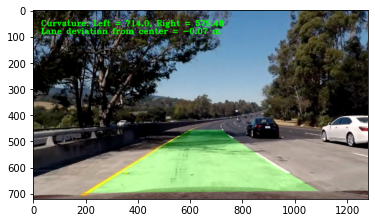

In [89]:
image=plt.imread('test_images/test5.jpg')
result=process_image(image)
plt.imshow(result)

In [90]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
!pip install moviepy

In [99]:

video_output = "output_images/project_video.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip1_output = clip1.fl_image(process_image)
%time clip1_output.write_videofile(video_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_images/project_video.mp4.
Moviepy - Writing video output_images/project_video.mp4




t:  10%|▉         | 124/1260 [02:01<15:45,  1.20it/s, now=None]


t:  20%|█▉        | 246/1260 [03:51<19:22,  1.15s/it, now=None]


t:  29%|██▉       | 368/1260 [05:24<11:07,  1.34it/s, now=None]


t:  39%|███▉      | 490/1260 [06:56<11:15,  1.14it/s, now=None]


t:  49%|████▊     | 612/1260 [08:38<07:56,  1.36it/s, now=None]


t:  58%|█████▊    | 734/1260 [10:27<06:34,  1.33it/s, now=None]


t:  68%|██████▊   | 856/1260 [11:57<04:59,  1.35it/s, now=None]


t:  78%|███████▊  | 978/1260 [13:28<03:29,  1.35it/s, now=None]


t:  87%|████████▋ | 1098/1260 [15:06<03:53,  1.44s/it, now=None]


t:  97%|█████████▋| 1218/1260 [16:40<00:35,  1.17it/s, now=None]


t:  28%|██▊       | 137/485 [55:51<04:14,  1.37it/s, now=None]  

Moviepy - Done !
Moviepy - video ready output_images/project_video.mp4
CPU times: user 16min 9s, sys: 38.1 s, total: 16min 47s
Wall time: 17min 24s


In [100]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))
